In [2]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
#     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

# print("Number of accelerators: ", strategy.num_replicas_in_sync)

In [4]:
strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [5]:
def get_model(
    handle="https://www.kaggle.com/models/spsayakpaul/mlp-mixer/frameworks/TensorFlow2/variations/mixer-b16-i21k-classification/versions/1",
    num_classes=10,
):

    hub_layer = hub.KerasLayer(handle, trainable=True)

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model

In [6]:
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

In [7]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = 224):
    def preprocess(image, label):
        # For training, do a random crop and horizontal flip.
        image = tf.image.resize(image, [image_size, image_size])
        image = (image - 127.5) / 127.5
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)

In [8]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [9]:
num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(test_ds)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_test}")

Number of training examples: 50000
Number of validation examples: 10000


In [10]:
train_dataset = make_dataset(train_ds, True)
test_dataset = make_dataset(test_ds, False)

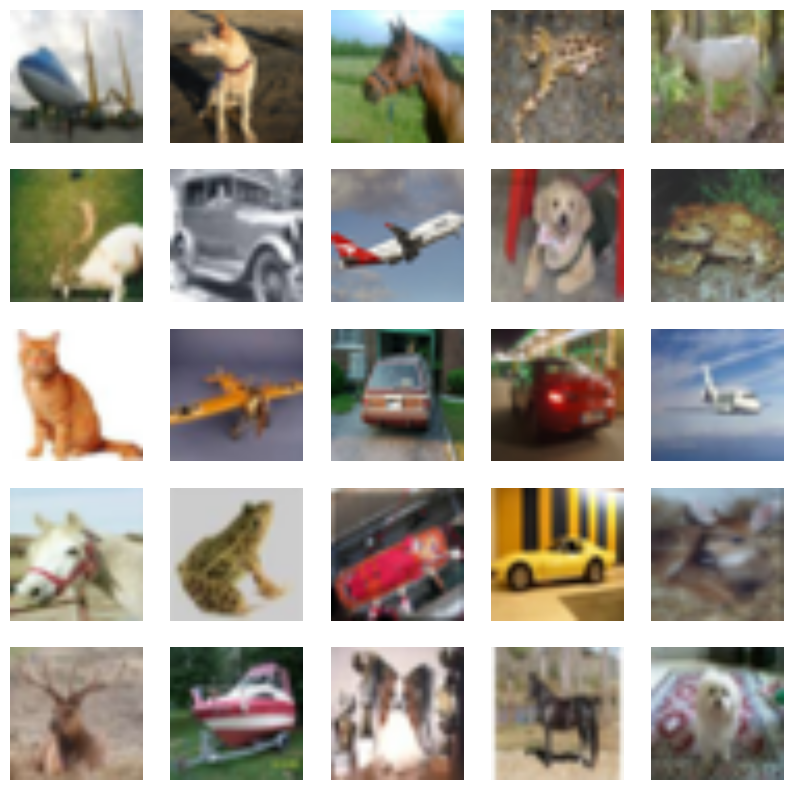

In [11]:
sample_images, _ = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow((sample_images[n].numpy() + 1) / 2)
    plt.axis("off")
plt.show()

In [12]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [13]:
EPOCHS = 10
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 5
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

3906


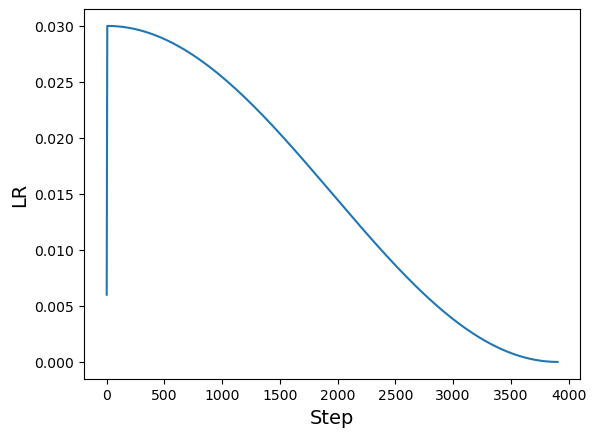

In [14]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [15]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss = keras.losses.SparseCategoricalCrossentropy()

In [16]:
with strategy.scope():
    model = get_model()
    model.summary()
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_dataset, epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 21843)             75908739  
                                                                 
 dense (Dense)               (None, 10)                218440    
                                                                 
Total params: 76,127,179
Trainable params: 218,440
Non-trainable params: 75,908,739
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 203s 476ms/step - loss: 19.2932 - accuracy: 0.2033
Epoch 2/10
391/391 [==============================] - 178s 456ms/step - loss: 9.8100 - accuracy: 0.4436
Epoch 3/10
391/391 [==============================] - 178s 456ms/step - loss: 5.3675 - accuracy: 0.6151
Epoch 4/10
391/391 [==============================] - 178s 456ms/step - loss: 2.9405 - accuracy: 0.7528
Epoch 5/10
391/39

In [17]:
loss, accuracy = model.evaluate(test_dataset)
print(f"accuracy: {accuracy * 100:.2f}%")

79/79 [==============================] - 41s 510ms/step - loss: 0.2712 - accuracy: 0.9456
accuracy: 94.56%


In [ ]:
plt.figure(figsize=(7, 7))
#history = history.history

plt.plot(history["loss"], label="train_loss")
#plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["accuracy"], label="train_accuracy")
#plt.plot(history["val_accuracy"], label="val_accuracy")

plt.legend()
plt.show()